<a href="https://colab.research.google.com/github/dKanikao26/Driver-Safety-Project/blob/main/902_rafdb_Inceptionresnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Input (100x100x3)
      ↓
EfficientNetV2L (pretrained on ImageNet, frozen)
      ↓
Flatten
      ↓
Dense(1024) → Dense(512) → Dense(256) → Dense(128) → Dense(64) → Dense(32)
      ↓
Dense(7, softmax) → Output: 7 emotion classes


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download tanishmittal/rafdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 99% 38.0M/38.2M [00:03<00:00, 18.3MB/s]
100% 38.2M/38.2M [00:03<00:00, 11.6MB/s]


In [ ]:
! unzip /content/rafdb.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/aligned/train/train_images/train_07274_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07275_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07276_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07277_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07278_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07279_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07280_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07281_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07282_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07283_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07284_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07285_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07286_a

In [17]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import cv2
import glob
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras import callbacks
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

In [ ]:
df = pd.read_csv('/content/dataset/train_labels.csv')
df.head()

,image,label
0,train_00001_aligned.jpg,5
1,train_00002_aligned.jpg,5
2,train_00003_aligned.jpg,4
3,train_00004_aligned.jpg,4
4,train_00005_aligned.jpg,5


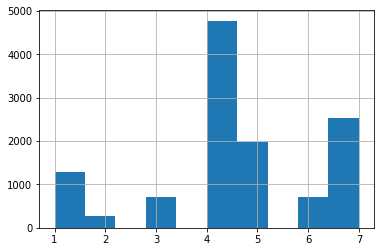

In [ ]:
df['label'].hist()

In [ ]:
input_tensor = tf.keras.Input(shape=(100, 100, 3))

In [ ]:
train_csv = pd.read_csv('/content/dataset/train_labels.csv')
test_csv = pd.read_csv('/content/dataset/test_labels.csv')
train_csv['label'] = train_csv['label'].astype(str)
test_csv['label'] = test_csv['label'].astype(str)

In [ ]:
datagen_train=ImageDataGenerator(rescale=1./255 ,  preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
train_generator=datagen_train.flow_from_dataframe(
dataframe=train_csv,
directory='/content/dataset/aligned/train/train_images' ,
x_col="image",
y_col="label",
batch_size=64,
color_mode='rgb',
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(100,100))

datagen_test=ImageDataGenerator(rescale=1./255 ,  preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

test_generator=datagen_test.flow_from_dataframe(
dataframe=test_csv,
directory="/content/dataset/aligned/test/test_images",
x_col="image",
y_col="label",
batch_size=64,
seed=42,
color_mode='rgb',
shuffle=True,
class_mode="categorical",
target_size=(100,100))

Found 12271 validated image filenames belonging to 7 classes.
Found 3068 validated image filenames belonging to 7 classes.


In [ ]:
img_width, img_height = 100, 100

input_tensor = tf.keras.Input(shape=(img_width, img_height, 3))
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
output = tf.keras.layers.Dense(7, activation='softmax')(x)
model = tf.keras.Model(base_model.input, output)

219055592/219055592 [==============================] - 11s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 49, 49, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 49, 49, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'binary_accuracy'])


In [ ]:
mch = callbacks.ModelCheckpoint('/fianl-model.h5' , monitor='val_loss' , mode ='min' , save_best_only=True)

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',classes = np.unique(train_generator.labels),y = train_generator.labels)
class_weights = {i : class_weights[i] for i in range(7)}


In [ ]:
model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=100, validation_data=test_generator, validation_steps=len(test_generator)  , class_weight = class_weights, callbacks =[mch])


Epoch 1/100
192/192 [==============================] - 134s 292ms/step - loss: 0.3767 - precision: 0.6251 - recall: 0.1792 - binary_accuracy: 0.8674 - val_loss: 0.5935 - val_precision: 0.5883 - val_recall: 0.4299 - val_binary_accuracy: 0.8756
Epoch 2/100
192/192 [==============================] - 49s 252ms/step - loss: 0.2717 - precision: 0.7089 - recall: 0.5150 - binary_accuracy: 0.9005 - val_loss: 0.5136 - val_precision: 0.7069 - val_recall: 0.5968 - val_binary_accuracy: 0.9071
Epoch 3/100
192/192 [==============================] - 48s 249ms/step - loss: 0.2169 - precision: 0.7610 - recall: 0.6444 - binary_accuracy: 0.9203 - val_loss: 0.2083 - val_precision: 0.7453 - val_recall: 0.6838 - val_binary_accuracy: 0.9214
Epoch 4/100
192/192 [==============================] - 45s 235ms/step - loss: 0.1878 - precision: 0.7930 - recall: 0.7087 - binary_accuracy: 0.9320 - val_loss: 0.2123 - val_precision: 0.7714 - val_recall: 0.7040 - val_binary_accuracy: 0.9279
Epoch 5/100
192/192 [==========

In [ ]:
from google.colab import files
files.upload()  # Upload `final-macro-model.zip` here


Saving final-macro-model.rar to final-macro-model.rar


In [ ]:
!unrar x /content/final-macro-model.rar /content/



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/final-macro-model.rar

Extracting  /content/final-macro-model.h5                                  0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99%

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!mv final-macro-model.h5 /content/drive/MyDrive/


mv: cannot stat 'final-macro-model.h5': No such file or directory


In [4]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/final-macro-model.h5')


In [5]:
results = model.evaluate(test_generator)
print(f"\n🔍 Model Evaluation Results:\n")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")


NameError: name 'test_generator' is not defined

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Class labels
labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))


In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kanikadhawan11","key":"c8e7673dc6f14280243db8281daf8551"}'}

In [7]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download kmirfan/micro-expressions

Dataset URL: https://www.kaggle.com/datasets/kmirfan/micro-expressions
License(s): unknown


In [8]:
! unzip /content/micro-expressions.zip

Streaming output truncated to the last 5000 lines.
  inflating: Micro_Expressions/train/happiness/happiness1041.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1042.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1043.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1044.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1045.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1046.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1047.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1048.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1049.jpg  
  inflating: Micro_Expressions/train/happiness/happiness105.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1050.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1051.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1052.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1053.jpg  
  inflating:

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (100, 100)  # Or (224, 224) depending on your model
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    '/content/Micro_Expressions/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/content/Micro_Expressions/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 6083 images belonging to 7 classes.
Found 1517 images belonging to 7 classes.


In [10]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense

# Use the second-last layer as feature extractor
x = model.layers[-2].output

# Add new output layer with correct number of micro-expression classes
new_output = Dense(train_generator.num_classes, activation='softmax', name="micro_output")(x)

# Create new model
micro_model = Model(inputs=model.input, outputs=new_output)


In [11]:
micro_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [12]:
history = micro_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Start small
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


191/191 ━━━━━━━━━━━━━━━━━━━━ 569s 1s/step - accuracy: 0.3737 - loss: 1.7477 - val_accuracy: 0.2307 - val_loss: 2.0433
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 78s 408ms/step - accuracy: 0.6297 - loss: 1.0301 - val_accuracy: 0.2248 - val_loss: 2.4397
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 78s 407ms/step - accuracy: 0.6802 - loss: 0.8708 - val_accuracy: 0.2696 - val_loss: 2.4465
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 81s 404ms/step - accuracy: 0.7334 - loss: 0.7393 - val_accuracy: 0.4258 - val_loss: 1.6533
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 78s 406ms/step - accuracy: 0.7868 - loss: 0.6030 - val_accuracy: 0.1800 - val_loss: 2.4051
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 78s 407ms/step - accuracy: 0.8276 - loss: 0.5106 - val_accuracy: 0.1971 - val_loss: 2.7636
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 77s 405ms/step - accuracy: 0.8603 - loss: 0.4441 - val_accuracy: 0.2696 - val_loss: 2.7522
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 404ms/step - accuracy: 0.8883 - loss: 0.3567 - val_a

In [19]:
micro_model.save('micro_finetuned_model.keras')#new model take keras




In [21]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!mv micro_finetuned_model.keras /content/drive/MyDrive/


In [23]:
# Evaluate the model
val_loss, val_accuracy = micro_model.evaluate(val_generator)

print(f"✅ Final Validation Accuracy: {val_accuracy * 100:.2f}%")


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.2027 - loss: 2.3582
✅ Final Validation Accuracy: 19.05%
